# FieldMesh Conversion

In [1]:
from pmd_beamphysics import FieldMesh

import numpy as np
import matplotlib.pyplot as plt

## 2D cylindrically symmetric RF gun FieldMesh

This data was originally generated using Superfish.

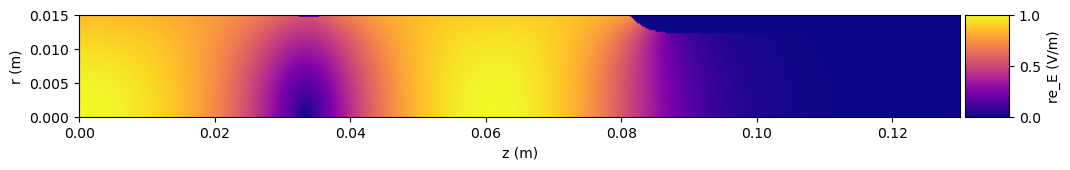

In [2]:
FM1 = FieldMesh('../data/rfgun.h5')
FM1.plot('re_E', aspect='equal', figsize=(12,4))

## 3D rectangular field from ANSYS 

In [3]:
FM3D = FieldMesh.from_ansys_ascii_3d(efile='../data/ansys_rfgun_2856MHz_E.dat',
                              hfile='../data/ansys_rfgun_2856MHz_H.dat',
                              frequency=2856e6)



FM3D

<FieldMesh with rectangular geometry and (3, 3, 457) shape at 0x7f4e38264310>

This will convert to 2D cylindrical:

In [4]:
FM2 = FM3D.to_cylindrical()
FM2

<FieldMesh with cylindrical geometry and (2, 1, 457) shape at 0x7f4df0de6c40>

Spacing is different:

In [5]:
FM1.dr, FM2.dr

(np.float64(0.00025), np.float64(0.001))

Set a scale to rotate and normalize Ez to be mostly real

In [6]:
E0 = FM2.components['electricField/z'][0,0,0]
FM2.scale = -np.exp(-1j * np.angle(E0)) / np.abs(E0) # - sign to agree with FM1

FM2.Ez[0,0,0]

np.complex128(-1-1.890985933883628e-16j)

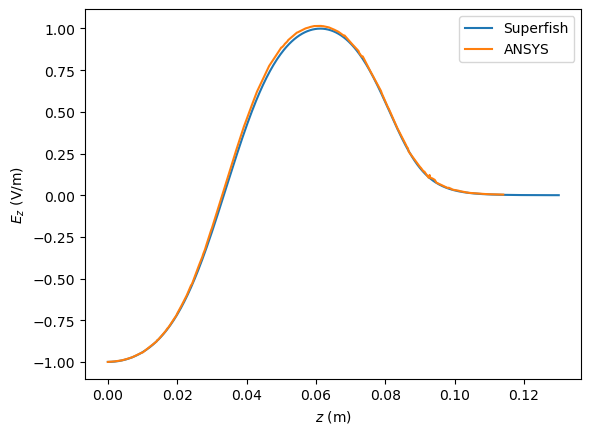

In [7]:
z1 = FM1.coord_vec('z')
z2 = FM2.coord_vec('z')


fig, ax = plt.subplots()
ax.plot(z1, np.real(FM1.Ez[0,0,:]), label='Superfish')
ax.plot(z2, np.real(FM2.Ez[0,0,:]), label='ANSYS')
ax.set_xlabel(r'$z$ (m)')
ax.set_ylabel(r'$E_z$ (V/m)')
plt.legend()


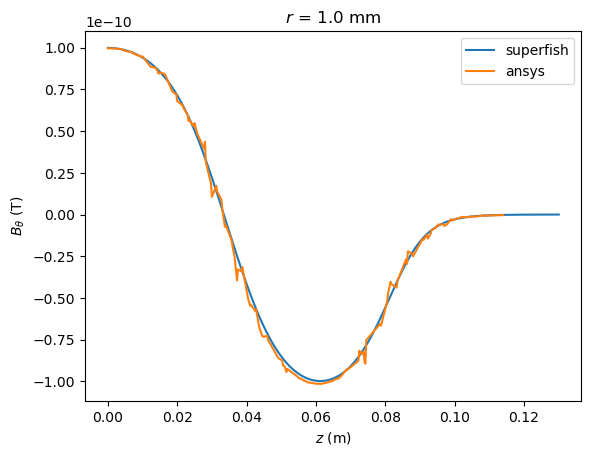

In [8]:
fig, ax = plt.subplots()
ax.plot(z1, np.imag(FM1.Btheta[4,0,:]), label='superfish')
ax.plot(z2, np.imag(FM2.Btheta[1,0,:]), label='ansys')

ax.set_title(fr'$r$ = {FM2.dr*1000} mm')
ax.set_xlabel(r'$z$ (m)')
ax.set_ylabel(r'$B_\theta$ (T)')
plt.legend()

The magnetic field is out of phase, so use the `im_` syntax:

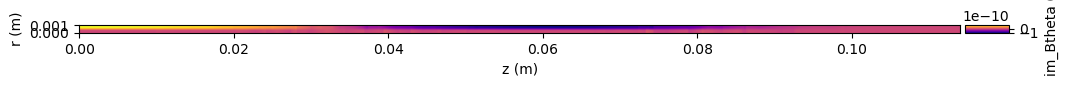

In [9]:
FM2.plot('im_Btheta', aspect='equal', figsize=(12,4))

Max on-axis field:

In [10]:
np.abs(FM2.Ez[0,0,:]).max()

np.float64(1.0153992993439902)

## Verify the oscillation

Complex fields oscillate as $e^{-i\omega t}$. For TM fields, the spatial components $E_z$ and $B_\theta$ near the axis 

$\Re E_{z} = -\frac{r}{2}\frac{\omega}{c^2} \Im B_\theta$


In [11]:
def check_oscillation(FM, label=''):

    c_light = 299792458.
    
    dr = FM.dr
    omega = FM.frequency*2*np.pi
    
    # Check the first off-axis grid points
    z0 = FM.z
    Ez0 = np.real(FM.Ez[0,0,:])
    B1 = -np.imag(FM.Btheta[1,0,:])
    
    plt.plot(z0, Ez0, label=r'$\Re \left( E_z\right)$')
    plt.plot(z0, B1*2/dr *c_light**2/omega, '--', label=r'$-\frac{r}{2}\frac{\omega}{c^2} \Im\left(B_\theta\right)$')
    plt.ylabel('field (V/m)')
    plt.xlabel('z (m)')
    plt.legend()
    plt.title(fr'Complex field oscillation{label}')

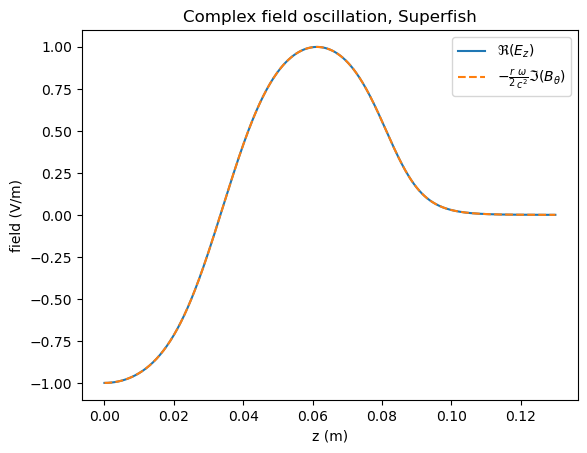

In [12]:
check_oscillation(FM1, ', Superfish')

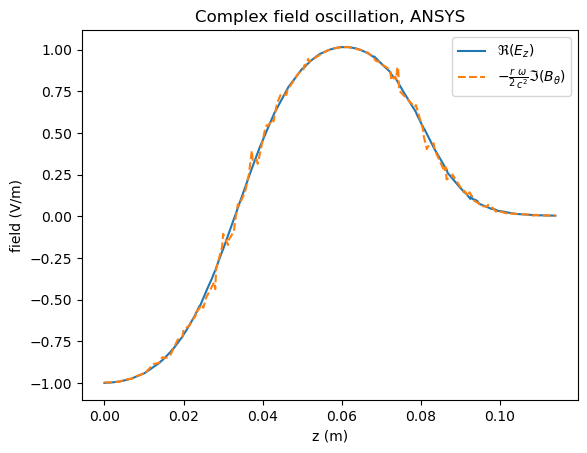

In [13]:
check_oscillation(FM2, ', ANSYS')